In [1]:
import sys
sys.path.append('./')
sys.path.append('./../../../../')
sys.path.append('./../../../../designer')
sys.path.append('./../../../../designer/script')

from spectrum import Spectrum
from film import MultiMaterialFilm, TwoMaterialFilm
from optimizer.adam import AdamThicknessOptimizer
from optimizer.archive.LM_gradient_descent import LM_optimize_d_simple
from design import BaseDesign

from utils.substitute import optimal_and_thin_film_approx_substitution_onestep_new, equal_optical_thickness_new, equal_optical_thickness
from utils.loss import calculate_RMS

import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
wls = np.linspace(390, 710, 320)
wls_more = np.linspace(300, 800, 500)

target_spec_params = 20., wls
target = Spectrum(*target_spec_params, np.ones_like(wls))

reverse = lambda arr: np.ascontiguousarray(np.flip(arr))
d_init = reverse(np.loadtxt('./before')) # NOTE: the structures are in the reverse order
materials_init = reverse(np.loadtxt('./before_materials', dtype='str'))
d_eqot_benchmark = reverse(np.loadtxt('./after'))
materials_eqot_benchmark = reverse(np.loadtxt('./after_materials', dtype='str'))

print(materials_eqot_benchmark)
print(d_eqot_benchmark)

film_init = MultiMaterialFilm(materials_init, 'SiO2_exp', d_init)
# xc
film_eqot_benchmark = MultiMaterialFilm(materials_eqot_benchmark, 'SiO2_exp', d_eqot_benchmark)
# ours
film_eqot = copy.deepcopy(film_init)
film_optim = copy.deepcopy(film_init)


all_films = [film_init, film_eqot_benchmark, film_eqot, film_optim]
for film in all_films:
    film.add_spec_param(*target_spec_params)

['MgF2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc'
 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc']
[ 93.333 117.232  51.859   5.183 135.813  11.153 207.212  24.928  12.108
  90.294  31.529  15.26   97.318]


In [3]:
# w/o GD. NOTE: need to wait for compilation of CUDA at first run
d_min = 5.
equal_optical_thickness_new(film_eqot, d_min)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min)
print(res)
print(calculate_RMS(film_optim, film_init))
print(calculate_RMS(film_eqot, film_init))

/home/vipuser/miniconda3/envs/tf_design_2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(2, [(1.0467859599567604+0j), (1.2082701290254758+0j)])


/home/vipuser/miniconda3/envs/tf_design_2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0.0037270362905111754
0.0037727095392426748


(0.97, 1.0)

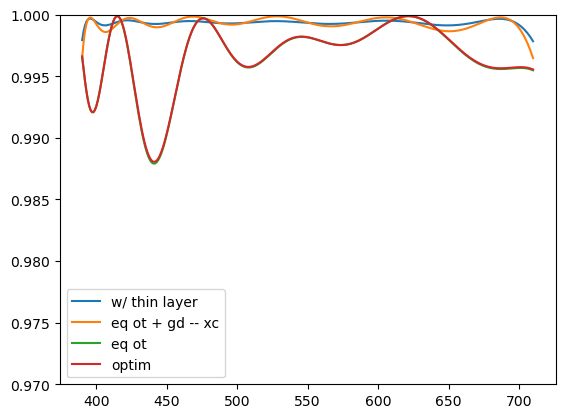

In [5]:
fig, ax = plt.subplots(1, 1)

ax.plot(wls, film_init.get_spec().get_T(), label='w/ thin layer')
ax.plot(wls, film_eqot_benchmark.get_spec().get_T(), label='eq ot + gd -- xc')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim')
ax.legend()
ax.set_ylim(0.97, 1)



This is weird. In our other experiments optim method seems to greatly outperform the equal ot...

Okay so i guess it is simply bad luck. Our strategy could not offer a result consistently outperforming eqot.

[18.49080238 30.01428613 10.         22.97316968 10.         10.
 10.         28.32352292 23.02230023 25.16145156 11.41168989 30.39819704
 27.64885282 15.24678221 14.63649934 14.6680902  17.08484486 10.
 19.63890037 10.         23.23705789 13.78987721 10.         18.32723687
 20.12139968 26.70351923 14.99347564 21.28468877 22.84829138 11.92900825
 23.15089704 14.41048247 12.30103186 29.97771075 30.31264066 27.16794696
 17.09227538 12.95344228 10.         19.80304987 13.4407647  20.9035382
 11.68777042 10.         16.17559963 24.25044569 10.         21.40136042
 21.93420559 14.69708911]
[ 18.49080238 134.7630127   23.02230023  25.16145156  11.41168989
  30.39819704  27.64885282  15.24678221  14.63649934  14.6680902
  73.76913257  46.6011254   20.12139968  26.70351923  14.99347564
  21.28468877  22.84829138  11.92900825  23.15089704  14.41048247
  12.30103186  29.97771075  30.31264066  27.16794696  17.09227538
  47.24050348  13.4407647   20.9035382   34.76753478  60.13581743
  21.9342055

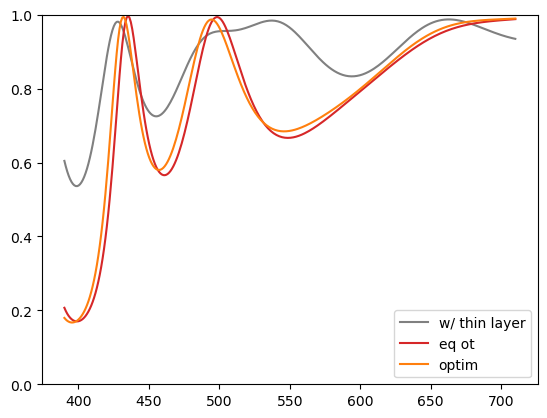

In [15]:
# toy scenario

d_min = 10
layer_number = 50
thin_number = 10

np.random.seed(42)
d_init = np.random.random(layer_number) * 20 + d_min + 1

thin_idx = np.arange(1, layer_number - 1)
np.random.shuffle(thin_idx)
thin_idx = thin_idx[:thin_number]

d_init[thin_idx] = d_min # artificial thin films
print(d_init)

film = TwoMaterialFilm('Ta2O5_xc', 'SiO2_xc', 'BK7', d_init)
film.add_spec_param(20., wls)

film_eqot = copy.deepcopy(film)
equal_optical_thickness_new(film_eqot, d_min + 1)
print(film_eqot.get_d())

film_optim = copy.deepcopy(film)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min + 1)
print('optim sub res:', res)
fig, ax = plt.subplots(1, 1)

ax.plot(wls, film.get_spec().get_T(), label='w/ thin layer', c='grey')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot', c='C3')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim', c='C1')
ax.legend()
ax.set_ylim(0., 1)

print(calculate_RMS(film, film_optim))
print(calculate_RMS(film, film_eqot))